In [1]:
# import necessary libraries
import sagemaker
from sagemaker.xgboost.estimator import XGBoost
from sagemaker.session import Session
from sagemaker.inputs import TrainingInput
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner
)
from sagemaker import get_execution_role
import boto3

role = get_execution_role()
default_bucket = "sagemaker-us-west-1-055338534628/customer-churn-ml-prediction/telco_churn_data"

## XGBoost Hyper-paramter Tuning and Training jobs

In [2]:
# Creating Training and Validation data channels from s3 buckets (saved in 'churn_data_prep.ipynb')
s3_input_train = TrainingInput(s3_data=f"s3://{default_bucket}/train/train.csv", content_type="csv")
s3_input_validation = TrainingInput(s3_data=f"s3://{default_bucket}/validation/validation.csv", content_type="csv")

Following hyper-parameters are fixed 

- `metric` (default value for binary classification) error rate  = #(wrong_cases)/#(total_cases) at threshold of 0.5.
- `objective`  logistic regression for binary classification, output probability 
- `num_round` controls the number of boosting rounds. This is essentially the subsequent models that are trained using the residuals of previous iterations. Again, more rounds should produce a better fit on the training data, but can be computationally expensive or lead to overfitting.
- `rate_drop` The dropout rate that specifies the fraction of previous trees to drop during the dropout.



In [3]:
fixed_hyperparameters = {
    "eval_metric": "auc",
    "objective":"binary:logistic",
    "num_round":"100",
    "rate_drop":"0.3",
}

In [5]:
sess = sagemaker.Session()
container = sagemaker.image_uris.retrieve("xgboost", sess.boto_region_name, "1.5-1")

estimator = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    hyperparameters=fixed_hyperparameters,
    instance_type="ml.m4.xlarge",
    output_path="s3://{}/output".format(default_bucket),
    sagemaker_session=sess
)

Following hyperparamters are varied for tuning:-

- `eta` controls how aggressive each round of boosting is. Larger values lead to more conservative boosting.
- `min_child_weight` Minimum sum of instance weight (hessian) needed in a child. If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, the building process gives up further partitioning. The larger the tree, the more conservative it is.
- `alpha` L1 regularization term on weights. Increasing this value makes models more conservative.
- `max_depth` Maximum depth of a tree. Increasing this value makes the model more complex and likely to be overfit.

In [6]:
hyperparameter_ranges = {
    "eta": ContinuousParameter(0, 1),
    "min_child_weight": ContinuousParameter(1, 10),
    "alpha": ContinuousParameter(0, 2),
    "max_depth": IntegerParameter(1, 10),
}

In [7]:
objective_metric_name = "validation:auc"

In [8]:
tuner = HyperparameterTuner(
    estimator,objective_metric_name,hyperparameter_ranges,max_jobs=10,max_parallel_jobs=2)

In [9]:
tuner.fit({
    "train":s3_input_train,
    "validation":s3_input_validation
    },include_cls_metadata=False)

................................................................................................................................................................................................................................................................!


In [10]:
tuning_job_result = boto3.client("sagemaker").describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner.latest_tuning_job.job_name
)
job_count = tuning_job_result["TrainingJobStatusCounters"]["Completed"]
print("%d training jobs have completed" %job_count)

10 training jobs have completed


'sagemaker-xgboost-220724-1222'

### Fetch Tuning results

In [22]:
import pandas as pd

tuner = sagemaker.HyperparameterTuningJobAnalytics(tuning_job_result["HyperParameterTuningJobName"])

full_df = tuner.dataframe()

objective = tuning_job_result["HyperParameterTuningJobConfig"]["HyperParameterTuningJobObjective"]
is_minimize = objective["Type"] != "Maximize"
objective_name = objective["MetricName"]

if len(full_df) > 0:
    df = full_df[full_df["FinalObjectiveValue"] > -float("inf")]
    if len(df) > 0:
        df = df.sort_values("FinalObjectiveValue", ascending=is_minimize)
        print("Number of training jobs with valid objective: %d" % len(df))
        print({"lowest": min(df["FinalObjectiveValue"]), "highest": max(df["FinalObjectiveValue"])})
        pd.set_option("display.max_colwidth", None)  # Don't truncate TrainingJobName
    else:
        print("No training jobs have reported valid results yet.")

df

Number of training jobs with valid objective: 10
{'lowest': 0.5, 'highest': 0.8238300085067749}


,alpha,eta,max_depth,min_child_weight,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
8,0.396407,0.170591,6.0,3.899328,sagemaker-xgboost-220724-1222-002-3c662943,Completed,0.82383,2022-07-24 12:24:25+00:00,2022-07-24 12:26:28+00:00,123.0
0,1.765089,0.203702,7.0,5.989222,sagemaker-xgboost-220724-1222-010-a984b07c,Completed,0.82091,2022-07-24 12:41:31+00:00,2022-07-24 12:43:30+00:00,119.0
9,1.814837,0.246807,9.0,9.900377,sagemaker-xgboost-220724-1222-001-c16dfbb7,Completed,0.81563,2022-07-24 12:24:18+00:00,2022-07-24 12:26:21+00:00,123.0
1,1.655230,0.732105,7.0,4.735255,sagemaker-xgboost-220724-1222-009-d75e6922,Completed,0.79497,2022-07-24 12:41:25+00:00,2022-07-24 12:43:37+00:00,132.0
4,1.490989,0.876990,10.0,6.434069,sagemaker-xgboost-220724-1222-006-59f62344,Completed,0.79132,2022-07-24 12:32:43+00:00,2022-07-24 12:34:58+00:00,135.0
7,0.132838,0.929801,6.0,4.478743,sagemaker-xgboost-220724-1222-003-6a2802fa,Completed,0.77801,2022-07-24 12:28:40+00:00,2022-07-24 12:30:53+00:00,133.0
6,0.016168,0.988365,7.0,6.318446,sagemaker-xgboost-220724-1222-004-2d89ab45,Completed,0.77581,2022-07-24 12:28:40+00:00,2022-07-24 12:30:48+00:00,128.0
2,0.220278,0.000000,10.0,5.900387,sagemaker-xgboost-220724-1222-008-2594a44a,Completed,0.50000,2022-07-24 12:37:17+00:00,2022-07-24 12:39:19+00:00,122.0
3,0.203222,0.000000,7.0,7.014315,sagemaker-xgboost-220724-1222-007-de060f5e,Completed,0.50000,2022-07-24 12:37:14+00:00,2022-07-24 12:39:22+00:00,128.0
5,0.000000,0.000000,1.0,2.735996,sagemaker-xgboost-220724-1222-005-a76b4391,Completed,0.50000,2022-07-24 12:32:54+00:00,2022-07-24 12:35:01+00:00,127.0


In [23]:
best_hyperparameters = tuning_job_result["BestTrainingJob"]["TunedHyperParameters"]
best_hyperparameters

{'alpha': '0.3964070604123471',
 'eta': '0.17059136644975958',
 'max_depth': '6',
 'min_child_weight': '3.8993275838608006'}

### Tuning job results vs time

The graph below shows how the objective metric changes over time, as the tuning job progresses. For Bayesian strategy, one should expect to see a general trend towards better results, but this progress will not be steady as the algorithm needs to balance exploration of new areas of parameter space against exploitation of known good areas. This can give you a sense of whether or not the number of training jobs is sufficient for the complexity of your search space.

In [29]:
import bokeh
import bokeh.io

bokeh.io.output_notebook()
from bokeh.plotting import figure, show
from bokeh.models import HoverTool


class HoverHelper:
    def __init__(self, tuning_analytics):
        self.tuner = tuning_analytics

    def hovertool(self):
        tooltips = [
            ("FinalObjectiveValue", "@FinalObjectiveValue"),
            ("TrainingJobName", "@TrainingJobName"),
        ]
        for k in self.tuner.tuning_ranges.keys():
            tooltips.append((k, "@{%s}" % k))

        ht = HoverTool(tooltips=tooltips)
        return ht

    def tools(self, standard_tools="pan,crosshair,wheel_zoom,zoom_in,zoom_out,undo,reset"):
        return [self.hovertool(), standard_tools]


hover = HoverHelper(tuner)

p = figure(plot_width=900, plot_height=500, tools=hover.tools(), x_axis_type="datetime", 
           x_axis_label="time", y_axis_label="AUC Score")
p.circle(source=df, x="TrainingStartTime", y="FinalObjectiveValue")
show(p)

Loading BokehJS ...

### Analyzing Correlation of Hyperparameters with Objective Metric

It's good to know the correlation between your objective metric and individual hyperparameters you've selected to tune. Having that insight will help you decide whether it makes sense to adjust search ranges for certain hyperparameters and start another tuning job. For example, if you see a positive trend between objective metric and a numerical hyperparameter, you probably want to set a higher tuning range for that hyperparameter in your next tuning job.



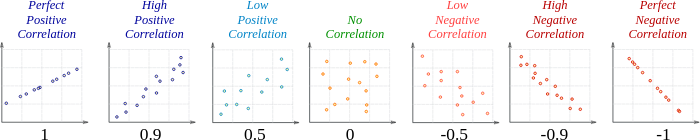

In [31]:
ranges = tuner.tuning_ranges
figures = []

for hp_name, hp_range in ranges.items():
    categorical_args = {}
    if hp_range.get("Values"):
        # This is marked as categorical.  Check if all options are actually numbers.
        def is_num(x):
            try:
                float(x)
                return 1
            except:
                return 0

        vals = hp_range["Values"]
        if sum([is_num(x) for x in vals]) == len(vals):
            # Bokeh has issues plotting a "categorical" range that's actually numeric, so plot as numeric
            print("Hyperparameter %s is tuned as categorical, but all values are numeric" % hp_name)
        else:
            # Set up extra options for plotting categoricals.  A bit tricky when they're actually numbers.
            categorical_args["x_range"] = vals

    # Now plot it
    p = figure(
        plot_width=500,
        plot_height=500,
        title="Objective vs %s" % hp_name,
        tools=hover.tools(),
        x_axis_label=hp_name,
        y_axis_label=objective_name,
        **categorical_args,
    )
    p.circle(source=df, x=hp_name, y="FinalObjectiveValue")
    figures.append(p)
show(bokeh.layouts.Column(*figures))

The scatter plot shows that the points are distributed quite apart from each other. Hence, we have set the ranges well for hyperparamter optimization.
